## ViT-VQGAN reconstruction
### Created by Corran (Corran#8565 in [LAION Discord](https://discord.gg/j5GdN49g))

In [2]:
#@title Setup
# pip install omegaconf einops
from IPython.display import clear_output
# clear_output()
# mkdir vit_vqgan
# %cd vit_vqgan
# gdown 1DbHEBNzjefNfwG0AKvYKB64if5Usua2n
# gdown 1-9INRFzvxDlQxyLX3fGA9ZnL3HXYyeTf
# gdown 1HzNvpeqvUTHz9tQOiV6G2r5sHKKhKQUZ
# gdown 1syv0t3nAJ-bETFgFpztw9cPXghanUaM6
# clear_output()

In [3]:
#@title Declare Dependencies
import sys,os
os.chdir("/workspace/home/nieshen-cx/enhancing-transformers/vit_vqgan")
sys.path.append("vit_vqgan")

import io
import PIL
import requests
import numpy as np
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.utils import save_image
import gc
import cv2
from matplotlib import pyplot as plt
from IPython.display import clear_output

from vitvqgan import ViTVQ
from PIL import Image
  
def show_ims(recon,original):
  fig = plt.figure(figsize=(10, 7))

  Image1 = np.array(original)
  Image2 = np.array(recon)
  fig.add_subplot(1, 2, 1)
    
  plt.imshow(Image1)
  plt.axis('off')
  plt.title("Original")
  fig.add_subplot(1,2,2)
    
  plt.imshow(Image2)
  plt.axis('off')
  plt.title("Reconstructed")

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

def preprocess(img):
    s = min(img.size)
    
    if s < 256:
        raise ValueError(f'min dim for image {s} < 256')
        
    r = 256 / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [256])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img

to_Pil=T.ToPILImage()


/workspace/home/nieshen-cx/anaconda3/envs/enhancing/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Restored from ./imagenet_vitvq_base.ckpt
original saved at vit_vqgan/original.png 
reconstructed saved at vit_vqgan/reconstructed.png 


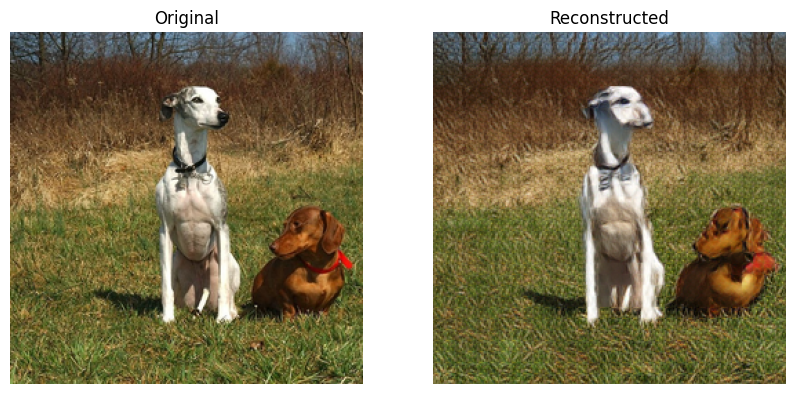

In [8]:
#@title Reconstruct Image
#@markdown image path can be local or a url with "https://""
gc.collect()
torch.cuda.empty_cache()

image_path="img3.png" #@param {type:"string"}
if "https" in image_path:
  original=download_image(image_path)
else:
  if os.path.exists(image_path):
    original=Image.open(image_path)
  else:
    print("Please check the image path")

encoder = {'dim': 768, 'depth': 12,
           'heads': 12, 'mlp_dim': 3072}
decoder = {'dim': 768, 'depth': 12,
           'heads': 12, 'mlp_dim': 3072}
quantizer = {'embed_dim': 32, 'n_embed': 8192}

image=preprocess(original).cuda()
clear_output()
model = ViTVQ(256, 8, encoder, decoder, quantizer, path='./imagenet_vitvq_base.ckpt').cuda()
recon, _ = model(image)

save_image(image, 'original.png')
save_image(recon, 'reconstructed.png')

recon=Image.open("reconstructed.png")
image=Image.open("original.png")

show_ims(recon,image)
print("original saved at vit_vqgan/original.png ")
print("reconstructed saved at vit_vqgan/reconstructed.png ")

In [9]:
# print model size 
def getModelSize(model):
    param_size = 0
    param_sum = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
        param_sum += param.nelement()
    buffer_size = 0
    buffer_sum = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
        buffer_sum += buffer.nelement()
    all_size = (param_size + buffer_size) / 1024 / 1024
    print('模型总大小为：{:.3f}MB'.format(all_size))
    return (param_size, param_sum, buffer_size, buffer_sum, all_size)

getModelSize(model)

模型总大小为：657.033MB


(688949388, 172237347, 0, 0, 657.0333366394043)